## Final Project: Fantasy Sports Assistant 

#### 1.1 Handle imports up-front 


In [1]:
import urllib.request
import pandas as pd
from bs4 import BeautifulSoup 

#### 2.0 Load the Dataset


In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Define the base URL structure
base_url = "https://www.footballguys.com/playerhistoricalstats?pos={}&yr={}&startwk={}&stopwk={}&profile=p"

# List of positions
positions = ['qb', 'rb', 'wr', 'te', 'flex']

# Initialize an empty list to store all data
all_player_data = []

# Loop over the years and weeks
for year in range(1996, 2025):  # From 1996 to 2024
    for week in range(1, 19):  # Week 1 to 18
        for pos in positions:  # Loop through positions
            # Create the URL for the current year, week, and position
            url = base_url.format(pos, year, week, week)
            
            # Send a GET request
            response = requests.get(url)
            if response.status_code != 200:
                print(f"Failed to retrieve data for {pos} - Week {week} of {year}")
                continue  # Skip this week if there's an issue
            
            # Parse the page content with BeautifulSoup
            soup = BeautifulSoup(response.text, 'html.parser')
            
            # Extract the table containing player stats
            table = soup.find('table')
            if not table:
                print(f"Table not found for {pos} - Week {week} of {year}")
                continue
            
            # Extract rows from the table (excluding header row)
            rows = table.find_all('tr')[1:]
            
            # Loop over rows and extract data
            for row in rows:
                cols = row.find_all('td')
                if len(cols) > 1:  # Ensure valid data is available
                    player_name = cols[0].text.strip()
                    position = cols[1].text.strip()
                    points = float(cols[2].text.strip()) if len(cols) > 2 else None
                    
                    # Store the data in a dictionary
                    player_info = {
                        "Year": year,
                        "Week": week,
                        "Player": player_name,
                        "Position": position,
                        "Points": points,
                    }
                    all_player_data.append(player_info)

# Convert the list into a DataFrame
df = pd.DataFrame(all_player_data)

# Display the first few rows
print(df.head())


In [17]:
print(df.columns)

Index(['Year', 'Week', 'Player', 'Position', 'Points'], dtype='object')


### 2. Data Preprocessing and Cleaning

In [20]:
df = pd.read_csv('fantasy_football_data_2024.csv')

# Convert 'Points' column to numeric (in case it's in string format)
df['Points'] = pd.to_numeric(df['Points'], errors='coerce')

# Handle missing values (e.g., fill with the mean or median)
df['Points'].fillna(df['Points'].median(), inplace=True)

# Check for duplicates
df.drop_duplicates(inplace=True)

# Ensure data types are correct
df['Year'] = df['Year'].astype(int)
df['Week'] = df['Week'].astype(int)

# Display the cleaned DataFrame
print(df.head())

   Year  Week  Player                Position  Points
0  2024     1       1          Josh Allen BUF    28.0
1  2024     1       2       Baker Mayfield TB    29.0
2  2024     1       3      Jayden Daniels WAS    24.0
3  2024     1       4       Lamar Jackson BAL    27.0
4  2024     1       5  Anthony Richardson IND    22.0


/tmp/ipykernel_1796/837469328.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Points'].fillna(df['Points'].median(), inplace=True)


### 3. Exploratory Data Analysis (EDA)

         Year         Week       Player       Points
count  6608.0  6608.000000  6608.000000  6608.000000
mean   2024.0     9.505599    54.841556    26.324001
std       0.0     5.279960    37.838918     3.201126
min    2024.0     1.000000     1.000000    20.000000
25%    2024.0     5.000000    23.000000    24.000000
50%    2024.0     9.000000    49.000000    26.000000
75%    2024.0    14.000000    80.000000    28.000000
max    2024.0    18.000000   159.000000    41.000000


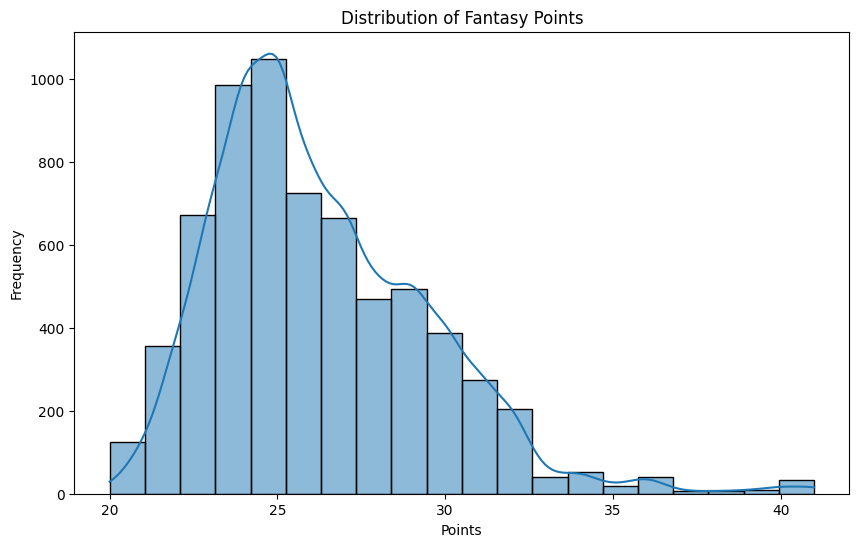

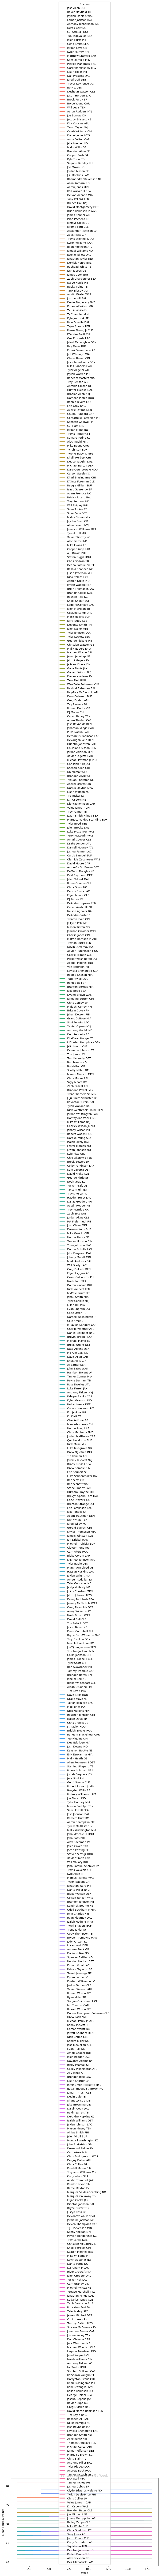

ValueError: could not convert string to float: 'Josh Allen BUF'

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Summary statistics
print(df.describe())

# Distribution of Fantasy Points
plt.figure(figsize=(10,6))
sns.histplot(df['Points'], kde=True, bins=20)
plt.title("Distribution of Fantasy Points")
plt.xlabel("Points")
plt.ylabel("Frequency")
plt.show()

# Points vs Week (For Trend Analysis)
plt.figure(figsize=(10,6))
sns.lineplot(data=df, x='Week', y='Points', hue='Position', estimator='mean')
plt.title("Fantasy Points Trend by Week")
plt.xlabel("Week")
plt.ylabel("Mean Fantasy Points")
plt.show()

# Correlation heatmap (if there are other numeric features)
correlation_matrix = df.corr()
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()